In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
laptop = 'forgach1mar822'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Height Data exploration

In [7]:
"C:/Users/forgach1mar822/Dropbox/1_ELTE/Szakdolgozat/Adatforras/Magasságadatok"
#ASTGTMV003_N47E019_dem.tif
#ASTGTMV003_N47E018_dem.tif
#N47E018_N47E019_merged.tif

'C:/Users/forgach1mar822/Dropbox/1_ELTE/Szakdolgozat/Adatforras/Magasságadatok'

In [5]:
src = rasterio.open('C:/Users/forgach1mar822/Dropbox/1_ELTE/Szakdolgozat/Adatforras/Magasságadatok/N47E018_N47E019_merge_BP.tif')
src
src.name

<open DatasetReader name='C:/Users/forgach1mar822/Dropbox/1_ELTE/Szakdolgozat/Adatforras/Magasságadatok/N47E018_N47E019_merge_BP.tif' mode='r'>

'C:/Users/forgach1mar822/Dropbox/1_ELTE/Szakdolgozat/Adatforras/Magasságadatok/N47E018_N47E019_merge_BP.tif'

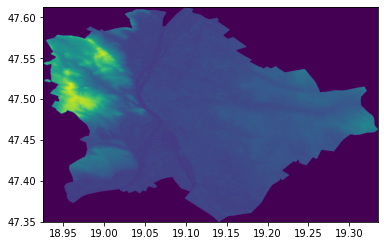

<AxesSubplot:>

In [6]:
#plt.figure(figsize=(30,20))
#plt.imshow(src.read(1), cmap='pink')

plt.show()
show(src)

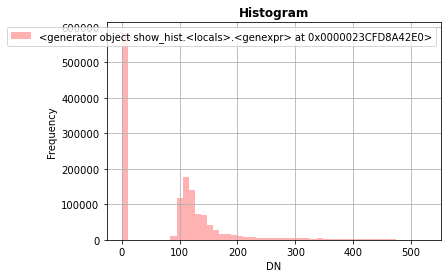

In [10]:
show_hist(src, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

In [11]:
src.width
src.height
src.bounds

1475

947

BoundingBox(left=18.925138889, bottom=47.349861111, right=19.334861111, top=47.612916667)

### Magasságadatok összekötése az állomásadatokkal

In [2]:
pickle_dirstring = 'C:/Users/' + laptop + '/Downloads/Egyéb/PICKLE/station_data.p'
station_data_df = pd.read_pickle(pickle_dirstring)
station_data_df.head(2)

,District,Station_id,Station,Rack number,lat,lon,Start date,End date,Move date,Shutdown start,Shutdown end,geometry
0,1.0,101.0,0101-Batthyány tér,28.0,47.506406,19.039172,2014-09-08,NaT,2015-01-15,2015-02-01,2015-04-22,POINT (19.03917 47.50641)
1,1.0,102.0,0102-Szilágyi Dezső tér,15.0,47.503424,19.039714,2014-09-08,NaT,NaT,NaT,NaT,POINT (19.03971 47.50342)


In [7]:
def raster_to_df(raster, raster_band=1):
    raster_bounds_left, raster_bounds_right, raster_bounds_bottom, raster_bounds_top, raster_width, raster_height = \
        get_raster_metadata(raster)
    data = get_data_from_raster(raster, raster_band)

    df_index = np.array(np.linspace(start=np.float64(raster_bounds_top),
                                    stop=np.float64(raster_bounds_bottom),
                                    num=raster_height),
                        dtype=np.float64)
    df_columns = np.array(
        np.linspace(start=np.float64(raster_bounds_left), stop=np.float64(raster_bounds_right), num=raster_width), dtype=np.float64)
    df = pd.DataFrame(data=data, index=df_index, columns=df_columns)
    df = df.astype(np.float64).replace(-9999,0)

    return df

def get_raster_metadata(dtm):
    dtm_bounds_left = dtm.bounds.left
    dtm_bounds_right = dtm.bounds.right
    dtm_bounds_bottom = dtm.bounds.bottom
    dtm_bounds_top = dtm.bounds.top
    dtm_width = dtm.meta['width']
    dtm_height = dtm.meta['height']
    return dtm_bounds_left, dtm_bounds_right, dtm_bounds_bottom, dtm_bounds_top, dtm_width, dtm_height

def get_data_from_raster(raster, band):
    return raster.read(band)

In [8]:
raster_df = raster_to_df(src, 1)

In [11]:
raster_df.columns = [round(float(x),6) for x in raster_df.columns]

In [12]:
raster_2_df = raster_df.reset_index()

In [13]:
raster_2_df.head(2)

,index,18.925139,18.925417,18.925695,18.925973,18.926251,18.926529,18.926807,18.927085,18.927363,...,19.332359,19.332637,19.332915,19.333193,19.333471,19.333749,19.334027,19.334305,19.334583,19.334861
0,47.612917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.612639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
raster_2_df['index'] = raster_2_df['index'].round(6).astype('str')

In [16]:
coord_list = []

raster_2_df_columns_list = raster_2_df.columns[1:]

for lon in tqdm(raster_2_df_columns_list):
    for lat in raster_2_df['index']:
        height = raster_2_df[raster_2_df['index'] == lat][lon].values[0]
        coord_list.append([lon, lat, height])      

100%|██████████████████████████████████████████████████████████████████████████████| 1475/1475 [16:10<00:00,  1.52it/s]

Wall time: 16min 10s


In [17]:
coord_list_df = pd.DataFrame(coord_list, columns = ['lon', 'lat', 'height'])
coord_list_df['lon'] = coord_list_df['lon'].astype('float64')
coord_list_df['lat'] = coord_list_df['lat'].astype('float64')
coord_list_df.head(1)

Wall time: 651 ms


,lon,lat,height
0,18.925139,47.612917,0.0


In [18]:
coord_list_df.height.describe()

count    1.396825e+06
mean     8.580034e+01
std      8.903064e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.050000e+02
75%      1.280000e+02
max      5.260000e+02
Name: height, dtype: float64

In [37]:
coord_list_df_sample = coord_list_df.sample(300000)
coord_list_df_sample.columns = ['lon', 'lat', 'height']

In [38]:
coord_list_gdf_sample = gpd.GeoDataFrame(coord_list_df_sample, geometry = gpd.points_from_xy(coord_list_df_sample.lon, coord_list_df_sample.lat))

<AxesSubplot:>

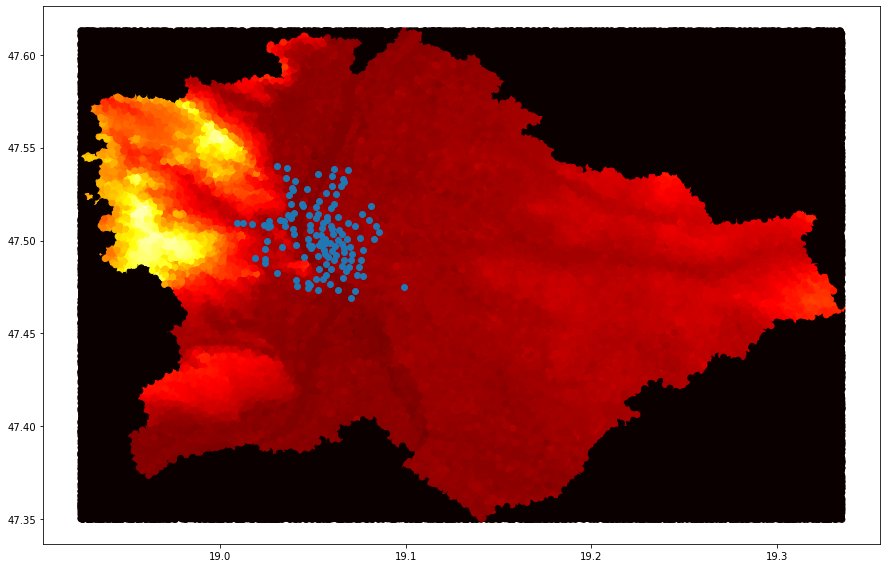

In [39]:
ax = coord_list_gdf_sample.plot(column = coord_list_gdf_sample.height, cmap = 'hot', figsize = (15,15))
station_data_df.geometry.plot(ax=ax)

### Nearest neighbours állomás magasságadatai

In [19]:
station_data_df = station_data_df[~station_data_df.lat.isna()]

In [20]:
coord_list_df = coord_list_df.reset_index(drop=True)
X=coord_list_df.loc[:,['lat','lon']]

station_data_df = station_data_df.reset_index(drop=True)

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree',n_jobs=-1).fit(X)
distances, indices = nbrs.kneighbors(station_data_df.loc[:,['lat','lon']])

#Make a dataframe with height data
height_df = pd.DataFrame(coord_list_df.height[indices.flatten()])
height_df = height_df.reset_index(drop=True)
station_data_df['height'] = height_df['height']

Wall time: 20.7 s


<AxesSubplot:>

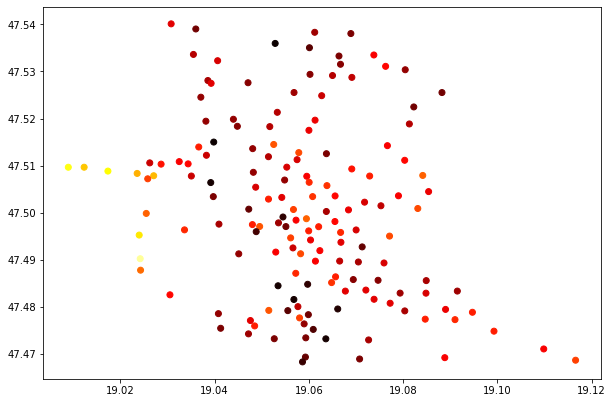

In [23]:
station_data_df.plot(column = station_data_df.height, cmap = 'hot', figsize = (10,10))

### Others

In [27]:
## BP legmagasabb, legalacsonyabb pontja
max(coord_list_df.height)
min(coord_list_df.height)

min(coord_list_df.height[coord_list_df.height > 0])

coord_list_df.height.describe()
#Hivatalosan János hegy (529) és Duna (96 m)

526.0

0.0

59.0

count    1.396825e+06
mean     8.580034e+01
std      8.903064e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.050000e+02
75%      1.280000e+02
max      5.260000e+02
Name: height, dtype: float64

In [26]:
## Bubi legmagasabb és legalacsonyabb
max(station_data_df.height)
min(station_data_df.height)

station_data_df.height.describe()

155.0

96.0

count    128.000000
mean     114.593750
std       10.138752
min       96.000000
25%      108.000000
50%      114.000000
75%      120.000000
max      155.000000
Name: height, dtype: float64